### Семинар 4. Seq2seq

В этом семинаре мы будем учить рекуррентную модель машинного перевода. Работать будем с описаниями отелей на русском и английском языке.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)

Для скачивания данных запустите код ниже.

In [1]:
from datasets import load_dataset


data = load_dataset('ascolda/ru_en_Crystallography_and_Spectroscopy')

In [2]:
def save_texts(lang: str):
    texts = '\n'.join([dic[lang].replace('\r', '').replace('\n', '') for dic in data['train']['translation']])
    with open(f'data/{lang}_texts.txt', 'w', encoding='utf-8') as f:
        print(texts, file=f)

In [3]:
save_texts('ru')
save_texts('en')

### Токенизация

Токенизировать наш текст будем с помощью BPE. Все необходимые функции для обучения своего токенизатора можно импортировать из библиотеки `huggingface`. Заметьте, что нам понадобится два токенизатора: для английского и русского языков. Конечно, можно обучить один для всего, но, так как английский текст никогда не пересекается с русским, в этом нет смысла (мы только ухудшим качество токенов).

In [4]:
from tokenizers import Tokenizer, processors
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from transformers import PreTrainedTokenizerFast, PreTrainedTokenizer, BertTokenizer, BertTokenizerFast, GPT2TokenizerFast

In [5]:
def train_tokenizer(files):
    unk_token = '[UNK]'  # token for unknown words
    spl_tokens = ['[UNK]', '[SEP]', '[CLS]', '[PAD]']  # special tokens

    tokenizer = Tokenizer(BPE(unk_token=unk_token))
    trainer = BpeTrainer(special_tokens=spl_tokens, vocab_size=30000)

    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.train(files, trainer)

    bos_token_id = tokenizer.token_to_id('[CLS]')
    eos_token_id = tokenizer.token_to_id('[SEP]')
    unk_token_id = tokenizer.token_to_id('[UNK]')
    pad_token_id = tokenizer.token_to_id('[PAD]')
    
    tokenizer.post_processor = processors.TemplateProcessing(
        single=f"[CLS]:0 $A:0 [SEP]:0",
        pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
        special_tokens=[("[CLS]", bos_token_id), ("[SEP]", eos_token_id)],
    )

    tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        bos_token='[CLS]',
        eos_token='[SEP]',
        unk_token='[UNK]',
        pad_token='[PAD]'
    )
    return tokenizer

In [6]:
en_tokenizer = train_tokenizer(['data/en_texts.txt'])
ru_tokenizer = train_tokenizer(['data/ru_texts.txt'])

### Датасет

Тут ничего сильно интересного. Читаем наши тексты, делим на тренировочную и тестовую выборки, а затем кладем все в `DataLoader` для дальнейшего удобства.

In [7]:
with open('data/en_texts.txt', encoding='utf-8') as f:
    en_texts = f.read().strip().split('\n')

with open('data/ru_texts.txt', encoding='utf-8') as f:
    ru_texts = f.read().strip().split('\n')

texts = list(zip(en_texts, ru_texts))

In [8]:
from sklearn.model_selection import train_test_split

train_texts, test_texts = train_test_split(texts, test_size=0.05)

In [9]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_texts, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_texts, batch_size=batch_size, shuffle=False, pin_memory=True)

In [10]:
ru_texts[:5]

['СТРУКТУРА НЕОРГАНИЧЕСКИХ СОЕДИНЕНИЙ',
 'Методами рентгеноструктурного анализа и электронно-зондового микроанализа исследована новая высокониобиевая разновидность ломоносовита с высокой степенью упорядочения атомов Ti и Nb.',
 'Упрощенная формула: Na10Ti2(Nb,Fe,Ti)2(Si2O7)2(PO4)2O4.',
 'Параметры триклинной элементарной ячейки: a = 5.411(1), b = 7.108(1), c = 14.477(2) Å, α = 99.78(1)\uf0b0, β = 96.59 (1)\uf0b0, γ = 90.26(1)\uf0b0, V = 544.94(5) Å3, Z = 1, пр. гр. P1.',
 'Обсуждается проблема распределения ниобия в минералах со структурным типом ломоносовита и родственными ему типами.']

In [11]:
tokenized = ru_tokenizer(ru_texts[:5], padding=True, return_tensors='pt')

In [12]:
print(tokenized['input_ids'])

tensor([[    2,  7009,  2657, 24535, 16570,     1,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3],
        [    2,  8505,  5200,  1223,   214,  4934,    14, 14998,  8181,  5536,
          8000, 24566,  1143, 13807,  7126,   223,  1697,  5115,  3654,   887,
          1536,   214,  1941,    15,     1,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3, 

In [13]:
ru_tokenizer.batch_decode(tokenized['input_ids'])

['[CLS] СТРУКТУРА НЕ ОРГАНИЧЕСКИХ СОЕДИНЕНИЙ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Методами рентгеноструктурного анализа и электронно - зондового микроанализа исследована новая высокониобие вая разновидность ломоносовита с высокой степенью упорядочения атомов Ti и Nb. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [14]:
print(tokenized['attention_mask'])

tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1

### Encoder-decoder model

Ниже написан код для модели, которую нам предстоит обучать. В качестве и энкодера, и декодера мы берем базовую однослойную версию GRU. При желании вы можете усложнить модель (учеличить размер, добавить механизм внимания и тд) и посмотреть, улучшает ли это результат.

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x, attention_mask):
        embed = self.embedding(x)

        output, h = self.gru(embed)

        # take output of the last token
        lens = attention_mask.sum(1)  # [bs]
        idx = (lens - 1).unsqueeze(1).expand(output.size(0), output.size(2)).unsqueeze(1) 
        # [bs, 1, d]

        # [bs, seq_len, d]
        output = output.gather(1, idx.to(device)).squeeze()

        # [1, bs, d]
        return self.fc(output).unsqueeze(0)


class Decoder(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, init_state):
        embed = self.embedding(x)

        output, h = self.gru(embed, init_state)

        output = self.fc(output)

        return output, h

class Model(nn.Module):
    def __init__(self, in_vocab_size, out_vocab_size, hidden_size=128):
        super().__init__()
        self.encoder = Encoder(in_vocab_size, hidden_size)
        self.decoder = Decoder(out_vocab_size, hidden_size)

    def forward(self, input_ids, output_ids, attention_mask):
        encoded = self.encoder(input_ids, attention_mask)
        logits, _ = self.decoder(output_ids, encoded)
        return logits


def clear_text(texts):
    clear_texts = []
    for text in texts:
        text = text.replace('[PAD]', '')
        cls_pos = text.find('[CLS]')
        if cls_pos > -1:
            text = text[cls_pos + len('[CLS]'):]

        sep_pos = text.find('[SEP]')
        if sep_pos > -1:
            text = text[:sep_pos]

        clear_texts.append(text.strip())

    return clear_texts


@torch.no_grad()
def translate(model, texts):
    model.eval()

    en_tokenized = en_tokenizer(texts, padding=True, return_tensors='pt')
    input_ids = en_tokenized['input_ids'].to(device)
    attention_mask = en_tokenized['attention_mask'].to(device)
    state = model.encoder(input_ids, attention_mask)

    cur_tokens = torch.full((len(texts), 1), ru_tokenizer.bos_token_id, device=device)
    output_ids = cur_tokens.clone()

    ended_texts = torch.zeros(len(texts))
    for i in range(256):
        logits, state = model.decoder(cur_tokens, state)

        next_tokens = logits.argmax(-1)

        cur_tokens = next_tokens
        output_ids = torch.cat((output_ids, cur_tokens), dim=1)
        
        ended_texts += (next_tokens.cpu().squeeze(1) == ru_tokenizer.eos_token_id)
        if torch.all(ended_texts > 0):
            break

    return ru_tokenizer.batch_decode(output_ids)

### Функция ошибки

Тут все почти так же, как для языковых моделей, за исключение обуславливания на входную последовательность
$$ L = -{\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

### Оценка качества: BLEU

Страндартно качество модели для машинного перевода оценивается с помощью [BLEU](https://en.wikipedia.org/wiki/BLEU). Она считает долю 1,2,3,4-грамм  переведенных текстов, которые содержатся в целевых, и находит их геометрическое среднее. Помимо этого добавляется штраф, если переведенный текст короче целевого.

<!-- While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute. -->

In [17]:
from nltk.translate.bleu_score import corpus_bleu

@torch.no_grad()
def compute_bleu(model, translated_text, target_text):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """

    return corpus_bleu(
        [[ref.split()] for ref in target_text],
        [trans.split() for trans in translated_text],
        smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
    ) * 100

### Обучение

In [18]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

model = Model(len(en_tokenizer), len(ru_tokenizer), hidden_size=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
accuracies = []
metrics = {'train_acc': [], 'train_loss': [], 'test_loss': [], 'test_bleu': []}

def train(model, dataloader, optimizer):
    model.train()
    
    criterion = nn.CrossEntropyLoss(ignore_index=ru_tokenizer.pad_token_id)

    for texts in tqdm(dataloader):
        en_texts, ru_texts = texts

        en_tokenized = en_tokenizer(en_texts, padding=True, return_tensors='pt')
        input_ids = en_tokenized['input_ids'].to(device)
        attention_mask = en_tokenized['attention_mask'].to(device)

        ru_tokenized = ru_tokenizer(ru_texts, padding=True, return_tensors='pt')
        output_ids = ru_tokenized['input_ids'].to(device)

        logits = model(input_ids, output_ids, attention_mask)

        shift_logits = logits[:, :-1].contiguous()
        shift_outputs = output_ids[:, 1:].contiguous()

        loss = criterion(shift_logits.view(-1, shift_logits.size(-1)), shift_outputs.view(-1))

        accuracy = (shift_logits.argmax(-1).view(-1) == shift_outputs.view(-1)).float()
        accuracy = accuracy[shift_outputs.view(-1) != ru_tokenizer.pad_token_id].mean()

        metrics['train_acc'].append(accuracy.item())
        metrics['train_loss'].append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        clear_output(wait=True)
        plt.figure(figsize=(15, 4))
        for i, (k, v) in enumerate(metrics.items()):
            plt.subplot(1, len(metrics), i + 1)
            plt.plot(v)
            plt.grid()
            plt.title(k, fontsize=16)

        plt.show()
        
def evaluate(model, dataloader):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=ru_tokenizer.pad_token_id)
    
    translated_text = []
    target_text = []
    losses = []
    for texts in tqdm(dataloader):
        en_texts, ru_texts = texts
        
        en_tokenized = en_tokenizer(en_texts, padding=True, return_tensors='pt')
        input_ids = en_tokenized['input_ids'].to(device)
        attention_mask = en_tokenized['attention_mask'].to(device)
        
        ru_tokenized = ru_tokenizer(ru_texts, padding=True, return_tensors='pt')
        output_ids = ru_tokenized['input_ids'].to(device)

        logits = model(input_ids, output_ids, attention_mask)

        shift_logits = logits[:, :-1].contiguous()
        shift_outputs = output_ids[:, 1:].contiguous()
        
        loss = criterion(shift_logits.view(-1, shift_logits.size(-1)), shift_outputs.view(-1))
        losses.append(loss.item())
        
        translations = clear_text(translate(model, en_texts))
    
        translated_text.extend(translations)
        target_text.extend(ru_texts)

    return {
        'bleu': compute_bleu(model, translated_text, target_text),
        'loss': np.mean(losses)
    }

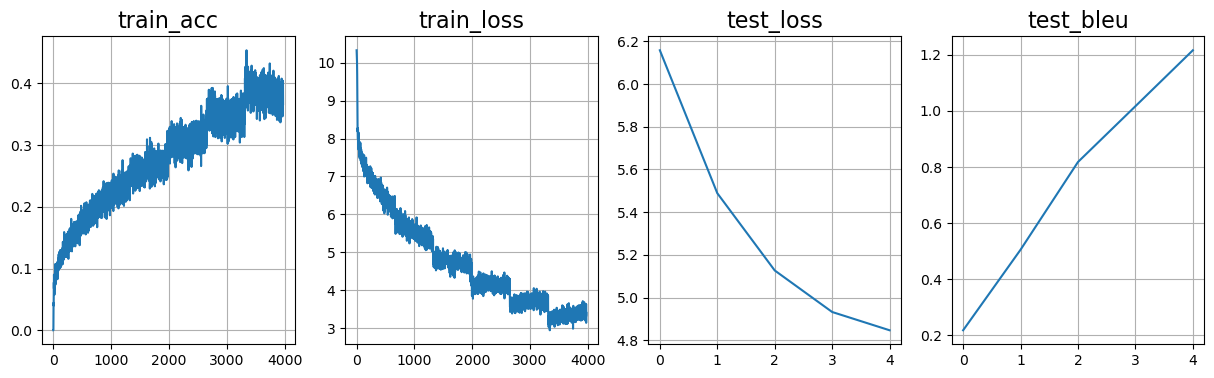

  0%|          | 0/35 [00:00<?, ?it/s]

In [20]:
for e in range(6):
    train(model, train_loader, optimizer)

    result = evaluate(model, test_loader)
    metrics['test_bleu'].append(result['bleu'])
    metrics['test_loss'].append(result['loss'])

In [21]:
torch.save(model.state_dict(), 'model.pt')

In [22]:
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [23]:
evaluate(model, test_loader)

  0%|          | 0/35 [00:00<?, ?it/s]

{'bleu': 1.0998453570662976, 'loss': 4.822218077523368}

In [24]:
en_texts, ru_texts = next(iter(test_loader))

In [25]:
translations = translate(model, en_texts)
clear_text(translations[:10])

['Показано, что комплекс пучка в качестве источника СИ поколения.',
 'Для описания пространственного распределения электронной плотности ( в ) состоянии ( а ) и ( 3 ) в процессе моделирования локального окружения переходных металлов, что приводит к формированию электронной плотности и состояний в системе зееманов ских состояний ( рис. 6в ), что приводит к формированию электронной плотности и их состояний.',
 'Карты малоугловой дифракции нейтронов в геометрии Брэгга ( рис. 2 ) и ( 10 ) и ( 7 ) намагничен ной функции магнитного рассеяния ( Q, E ) и ( 101 ) и ( 7 ) и ( 7 ) и ( 7 ) и ( 7 ) и ( 7 ) и ( 7 ) и ( 7 ) и ( 7 ) и ( 7 ) и ( 7 ).',
 'В качестве альтернати вой модели используется активная Го ль ду с энергией активации “ SnS2 - й ” с высокой степенью выпрям ленности до конца для создания стабильных детекторов в качестве полярного.',
 'Это говорит о том, что изменение контраста в области малых углов наблюдаются только при изменении знака рефлексов.',
 'Плотность керамик холодного прес

In [26]:
for en, ru, tr in zip(en_texts[:10], ru_texts[:10], clear_text(translations[:10])):
    print(en)
    print(ru)
    print(tr)
    print()

It was shown that a proton beam with a current of 80–85 mA on the target must be provided.
Показано, что на мишень требуется протонный пучок с током 80–85 мА.
Показано, что комплекс пучка в качестве источника СИ поколения.

The revealed closeness of the barriers of correlated librational motion (Uβ) and the barriers of local segmental mobility (Uα), determined based on the Tg values using the DSC method, confirms that the activation barrier of conformational mobility in a polymer chain changes only slightly in a wide temperature range (T > Tβ) only due to a change in the interchain interactions and remains close to Uβ.
Выявленная в настоящей работе близость барьеров коррелированного либрационного движения (Uβ) и барьеров локальной сегментальной подвижности (Uα), определенных по Тg методом ДСК, подтверждает, что активационный барьер конформационной подвижности в полимерной цепи мало изменяется в широком интервале температур Т > Тβ лишь в силу изменения межцепочечных взаимодействий, оста